# Explorer notebook

### Imports

In [1]:
import os
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import pymysql


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [3]:
# Christian's notebook >> not needed for now
#import dash
#import dash_core_components as dcc
#import dash_html_components as html
#from dash.dependencies import Input, Output
#import plotly.graph_objs as go
#import dash_table

### Connection to DB

In [4]:
# Connexion database
db_user = os.getenv('IMPRESSO_MYSQL_USER')
db_host = os.getenv('IMPRESSO_MYSQL_HOST')
db_name = os.getenv('IMPRESSO_MYSQL_DB')
db_password = os.getenv('IMPRESSO_MYSQL_PWD')
db_url = f'mysql://{db_user}:{db_password}@{db_host}/{db_name}?charset=utf8'
engine = create_engine(db_url, poolclass=NullPool)

### Example from Christian

In [5]:
data = pd.read_sql('SELECT impresso.issues.id, impresso.issues.year, impresso.issues.month, impresso.issues.day, impresso.issues.newspaper_id, impresso.newspapers.title FROM impresso.issues, impresso.newspapers WHERE impresso.newspapers.id = impresso.issues.newspaper_id ORDER BY impresso.issues.year ASC, impresso.issues.month ASC, impresso.issues.day ASC', engine)


OperationalError: (MySQLdb._exceptions.OperationalError) (1045, "Access denied for user 'impr_lausanne_ro'@'tsf-460-wpa-1-148.epfl.ch' (using password: YES)") (Background on this error at: http://sqlalche.me/e/e3q8)

In [6]:
data.head()

,id,year,month,day,newspaper_id,title
0,EXP-1740-01-01-a,1740,1,1,EXP,L'Express
1,EXP-1740-01-29-a,1740,1,29,EXP,L'Express
2,EXP-1740-04-04-a,1740,4,4,EXP,L'Express
3,EXP-1740-07-14-a,1740,7,14,EXP,L'Express
4,NZZ-1780-01-12-a,1780,1,12,NZZ,Neue Zürcher Zeitung


In [7]:
data['datetime'] = pd.to_datetime(data.year*10000+data.month*100+data.day,format='%Y%m%d')


In [8]:
data.head()

,id,year,month,day,newspaper_id,title,datetime
0,EXP-1740-01-01-a,1740,1,1,EXP,L'Express,1740-01-01
1,EXP-1740-01-29-a,1740,1,29,EXP,L'Express,1740-01-29
2,EXP-1740-04-04-a,1740,4,4,EXP,L'Express,1740-04-04
3,EXP-1740-07-14-a,1740,7,14,EXP,L'Express,1740-07-14
4,NZZ-1780-01-12-a,1780,1,12,NZZ,Neue Zürcher Zeitung,1780-01-12


### Explorer

In [9]:
newspapers_df = pd.read_sql('SELECT * FROM impresso.newspapers;', engine)
issues_df = pd.read_sql('SELECT * FROM impresso.issues;', engine)

In [10]:
newspapers_df.head(5)

,id,title,start_year,end_year,availability_eta
0,,La Sentinelle,NaN,NaN,None
1,24HEURES,24Heures,1762.0,2018.0,None
2,actionfem,L'Action féminine,1927.0,1940.0,None
3,AMI,L’ami du peuple,1878.0,1922.0,None
4,armeteufel,Arme Teufel,1903.0,1929.0,None


In [11]:
issues_df.head(5)

,id,year,month,day,edition,access_rights,created,last_modified,is_damaged,s3_version,newspaper_id
0,actionfem-1927-10-15-a,1927,10,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
1,actionfem-1927-11-15-a,1927,11,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
2,actionfem-1927-12-15-a,1927,12,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
3,actionfem-1928-01-15-a,1928,1,15,a,Closed,2019-06-15 12:22:41,NaT,0,,actionfem
4,actionfem-1928-02-15-a,1928,2,15,a,Closed,2019-06-15 12:22:41,NaT,0,,actionfem


### Number of newspaper issues by year/decade

#### By year

In [12]:
issue_per_np_year = issues_df.groupby(['newspaper_id', 'year']).count()

In [13]:
nb_issue_per_np_year_id = issue_per_np_year['id']

In [14]:
nb_issue_per_np_year_id2 = issue_per_np_year.loc[:,'id']

In [15]:
# Check if all columns have the same number of lines
for col in issues_df.columns :
    if not col=="year" and not col=="newspaper_id" and not nb_issue_per_np_year_id.equals(issue_per_np_year[col]) :
        print("Problem with column {}".format(col))

Problem with column last_modified


Column last_modified is often NaT, which is why the count is not the same. For that others we always have the same number so we can take any column (and we take 'id').

In [16]:
nb_issue_per_np_year_id.head(5)

newspaper_id  year
BDC           1839     23
CDV           1843    104
              1844     98
              1849    102
              1850    105
Name: id, dtype: int64

In [17]:
#TODO > convert to df properly to plot
#nb_issue_per_np_year_id_df = nb_issue_per_np_year_id.to_frame('count')

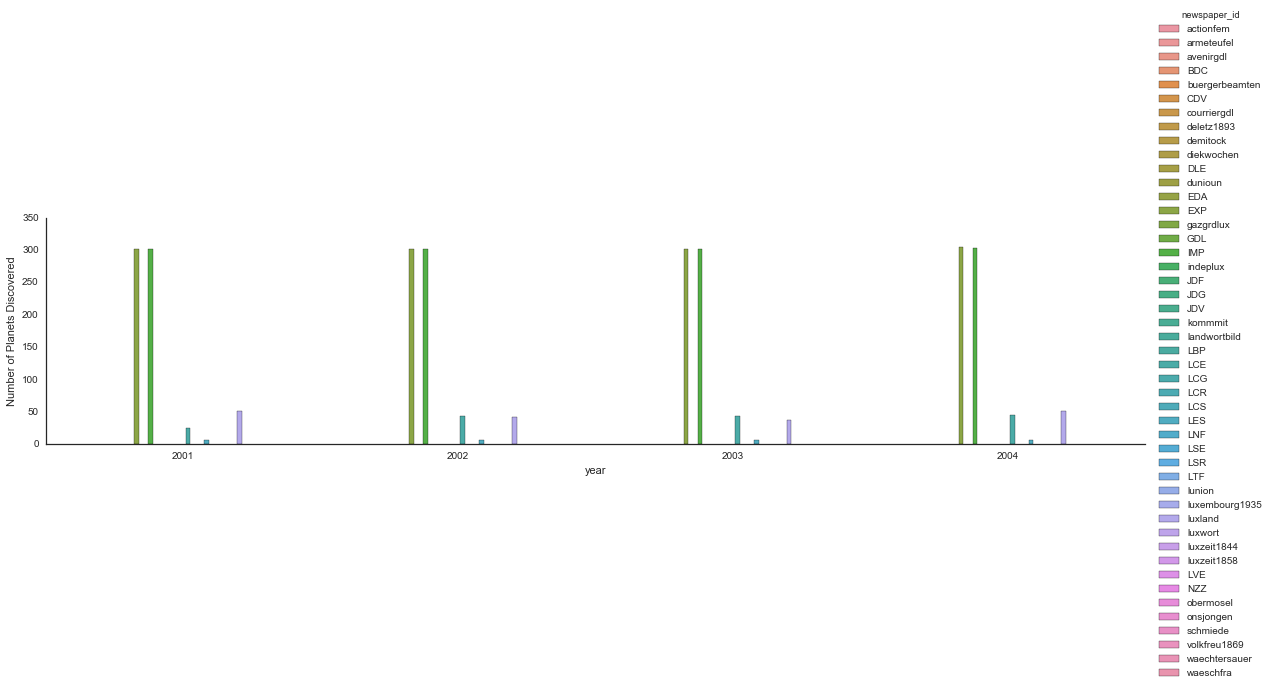

In [18]:
# TEST >> modify
sns.set()
with sns.axes_style('white'):
    g = sns.factorplot("year", data=issues_df, aspect=4.0, kind='count',
                       hue='newspaper_id', order=range(2001, 2005))
    g.set_ylabels('Number of Planets Discovered')

#### By decade

In [19]:
# Create new decade column
issues_df['decade'] = issues_df.apply(lambda row: row.year-row.year%10, axis = 1) 

In [20]:
issue_per_np_decade = issues_df.groupby(['newspaper_id', 'decade']).count()

In [21]:
# convert to df in order to plot
nb_issue_per_np_decade_id = issue_per_np_decade['id']
nb_issue_per_np_decade_id = nb_issue_per_np_decade_id.reset_index(name='count')
nb_issue_per_np_decade_id.head(5)

,newspaper_id,decade,count
0,BDC,1830,23
1,CDV,1840,304
2,CDV,1850,896
3,DLE,1900,4
4,DLE,1910,398


Remark : same check as above > only difference is with column last_modified

TypeError: 'NoneType' object is not iterable

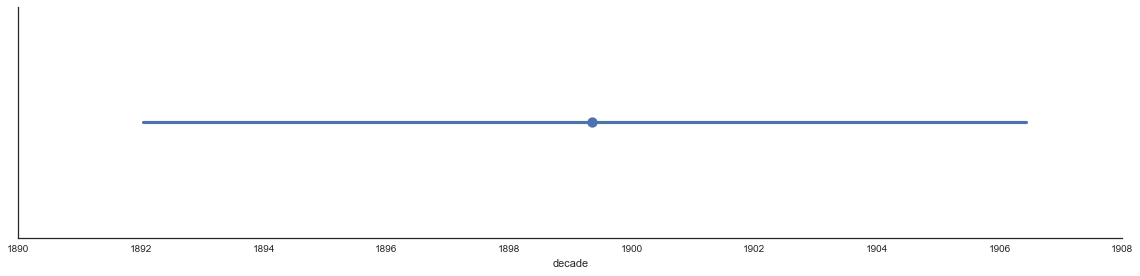

In [22]:
#TODO : plot >> fix
with sns.axes_style('white'):
    g = sns.factorplot("decade", data=nb_issue_per_np_decade_id, aspect=4.0,hue='newspaper_id')
    g.set_ylabels('Number of Planets Discovered')

#### By provenance (CH/Lux)

By language (de, fr)